### Recycling Robot

In [1]:
import numpy as np
from dataclasses import dataclass
from typing import Dict, Tuple, List
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ---------------- Config ----------------
GAMMA = 0.95               # Discount factor 
TD_LR = 0.1                # Learning rate for TD    
EPOCHS = 50                # Number of independent training cycles
STEPS_PER_EPOCH = 1000     # Steps per epoch per training cycle
NUM_RUNS = 10              # Multiple trainings to average curves
EPSILON = 0.05             # Probability of exploring random actions

# ---------------- Scenario grids ----------------
R_SEARCH_GRID = 5          # Reward for finding a can
R_WAIT_GRID   = 1          # Reward for waiting
RESCUE_PENALTY = -5.0      # Penalty for being rescued
ALPHA_GRID = [0.3, 0.6, 0.9] # Risky searching, Moderate, Very Safe (Probability that the battery stay High after a Search)
BETA_GRID =  [0.3, 0.6, 0.9] # Dangerous to search, Moderate, Very Safe (Probability that the battery stay Low after a Search)

# --------------- Environment ---------------
STATE_H, STATE_L = 0, 1
A_SEARCH, A_WAIT, A_RECHARGE = 0, 1, 2
STATE_NAMES = ["high", "low"]
ACTION_NAMES = ["search", "wait", "recharge"]
START_STATE = 0            
BASE_SEED = 2025

# Files
REWARDS_PATH = "rewards.txt"           
REWARDS_FIG = "accumulated_reward.png"
POLICY_HEATMAP_FIG = "optimal_policy_heatmap.png"


In [3]:
@dataclass
class Params:
    alpha: float
    beta: float
    r_search: int
    r_wait: int
    gamma: float
    rescue_penalty: float

def valid_actions(s: int) -> List[int]:
    return [A_SEARCH, A_WAIT] if s == STATE_H else [A_SEARCH, A_WAIT, A_RECHARGE]

def step_env(rng: np.random.Generator, s: int, a: int, p: Params) -> Tuple[int, float]:
    if s == STATE_H:
        if a == A_SEARCH:
            r = p.r_search
            s_next = STATE_H if rng.random() < p.alpha else STATE_L
            return s_next, r
        elif a == A_WAIT:
            return STATE_H, p.r_wait
        else:
            raise ValueError("Recharge invalid in HIGH")
    else:
        if a == A_SEARCH:
            if rng.random() < p.beta:
                return STATE_L, p.r_search
            else:
                return STATE_H, p.rescue_penalty
        elif a == A_WAIT:
            return STATE_L, p.r_wait
        elif a == A_RECHARGE:
            return STATE_H, 0.0
        else:
            raise ValueError("Unknown action")

In [4]:
def choose_action(rng: np.random.Generator, s: int, V: np.ndarray, p: Params, epsilon: float) -> int:
    """
    ε-greedy policy: with prob ε choose random valid action, else choose the action that maximizes the one-step TD target.
    """
    valid = valid_actions(s)

    # Exploration
    if rng.random() < epsilon: return rng.choice(valid)

    # Exploitation: estimate each action by 1-step lookahead using current V
    q_values = []
    for a in valid:
        # Expectation of next state value
        if s == STATE_H: # state HIGH
            if a == A_SEARCH:
                q = p.r_search + p.gamma * (p.alpha * V[STATE_H] + (1 - p.alpha) * V[STATE_L])
            elif a == A_WAIT:
                q = p.r_wait + p.gamma * V[STATE_H]
            else:
                q = -np.inf
        else:            # state LOW
            if a == A_SEARCH:
                q = p.beta * (p.r_search + p.gamma * V[STATE_L]) \
                  + (1 - p.beta) * (p.rescue_penalty + p.gamma * V[STATE_H])
            elif a == A_WAIT:
                q = p.r_wait + p.gamma * V[STATE_L]
            elif a == A_RECHARGE:
                q = 0.0 + p.gamma * V[STATE_H]
        q_values.append(q)

    # Greedy choice
    best_idx = int(np.argmax(q_values))
    return valid[best_idx]

def td_update(V: np.ndarray, s: int, r: float, s_next: int, p: Params, lr: float) -> None:
    """
    Update value function V using TD(0).
    """
    s = int(s)
    s_next = int(s_next)
    V[s] += lr * (r + p.gamma * V[s_next] - V[s])

def train_td(rng: np.random.Generator, p: Params, epochs: int, steps_per_epoch: int, lr: float, epsilon: float) -> np.ndarray:
    """
    Train the Recycling Robot with TD learning.
    
    Returns:
        V: learned state values
    """
    V = np.zeros(2)     # Two states: High, Low

    for ep in range(epochs):
        s = STATE_H  
        for _ in range(steps_per_epoch):
            a         = choose_action(rng, s, V, p, epsilon)
            s_next, r = step_env(rng, s, a, p)
            td_update(V, s, r, s_next, p, lr)
            s = s_next  
    return V

In [5]:
def run_experiments(p: Params, num_runs: int, epochs: int, steps_per_epoch: int,
lr: float, epsilon: float, seed: int = BASE_SEED) -> np.ndarray:
    """
    Run multiple training runs to average rewards.
    
    Returns:
        rewards_avg: average accumulated rewards per epoch
    """
    rewards_all = np.zeros((num_runs, epochs))

    for run in range(num_runs):
        rng = np.random.default_rng(seed + run)
        V = np.zeros(2)  # reset value function each run

        for ep in range(epochs):
            s = STATE_H
            total_reward = 0.0

            for _ in range(steps_per_epoch):
                a = choose_action(rng, s, V, p, epsilon)
                s_next, r = step_env(rng, s, a, p)
                td_update(V, s, r, s_next, p, lr)
                total_reward += r
                s = s_next

            rewards_all[run, ep] = total_reward

    # Average over runs
    rewards_avg = rewards_all.mean(axis=0)
    np.savetxt(REWARDS_PATH, rewards_avg, fmt="%.4f")
    return rewards_avg, V


def plot_rewards_curve(rewards_avg: np.ndarray):
    """
    Plot accumulated rewards over epochs.
    """
    plt.figure(figsize=(8,5))
    plt.plot(rewards_avg, label="Average total reward")
    plt.xlabel("Epoch")
    plt.ylabel("Accumulated reward")
    plt.title("Recycling Robot – Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(REWARDS_FIG, dpi=300)
    # plt.close()


def plot_policy_heatmap(V: np.ndarray, p: Params):
    """
    Plot the optimal policy as a heatmap.
    """
    policy = {}
    for s in [STATE_H, STATE_L]:
        valid = valid_actions(s)
        qvals = [0.0] * len(ACTION_NAMES)
        for a in valid:
            if s == STATE_H:
                if a == A_SEARCH:
                    qvals[a] = p.r_search + p.gamma * (p.alpha * V[STATE_H] + (1 - p.alpha) * V[STATE_L])
                elif a == A_WAIT:
                    qvals[a] = p.r_wait + p.gamma * V[STATE_H]
            else:  # state = LOW
                if a == A_SEARCH:
                    qvals[a] = p.beta * (p.r_search + p.gamma * V[STATE_L]) \
                             + (1 - p.beta) * (p.rescue_penalty + p.gamma * V[STATE_H])
                elif a == A_WAIT:
                    qvals[a] = p.r_wait + p.gamma * V[STATE_L]
                elif a == A_RECHARGE:
                    qvals[a] = 0.0 + p.gamma * V[STATE_H]

        qvals = np.array(qvals)
        probs = np.exp(qvals - np.max(qvals))
        probs /= probs.sum()
        policy[s] = probs

    heatmap_data = np.zeros((len(STATE_NAMES), len(ACTION_NAMES)))
    for s in policy: heatmap_data[s, :] = policy[s]

    plt.figure(figsize=(6,3))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=ACTION_NAMES, yticklabels=STATE_NAMES, cmap="Blues")
    plt.title("Optimal Policy (action probabilities)")
    plt.savefig(POLICY_HEATMAP_FIG, dpi=300)
    # plt.close()

### Experimental Setup

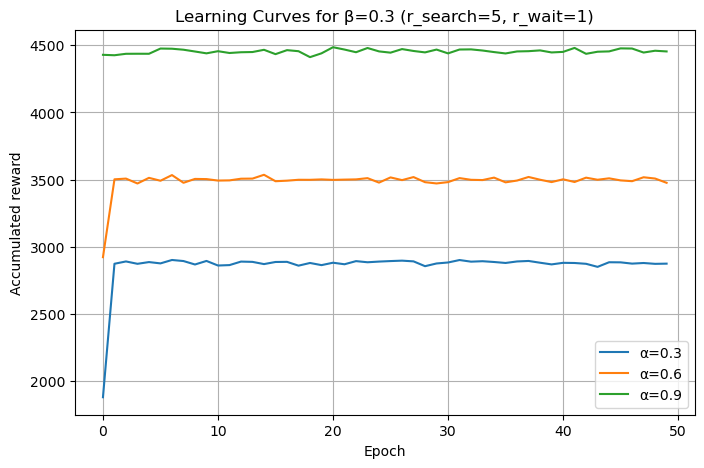

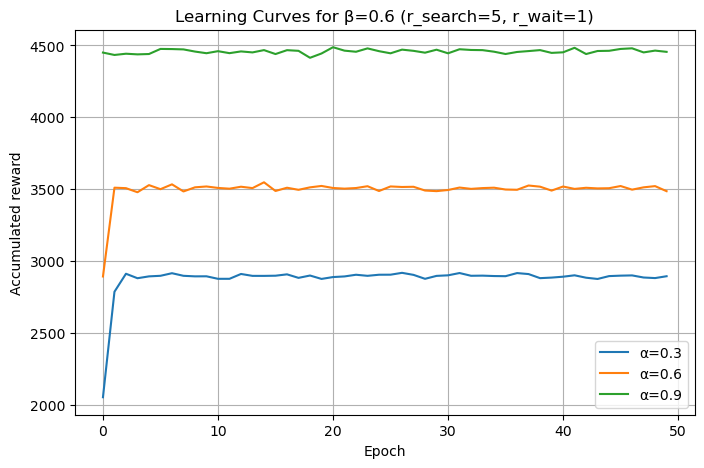

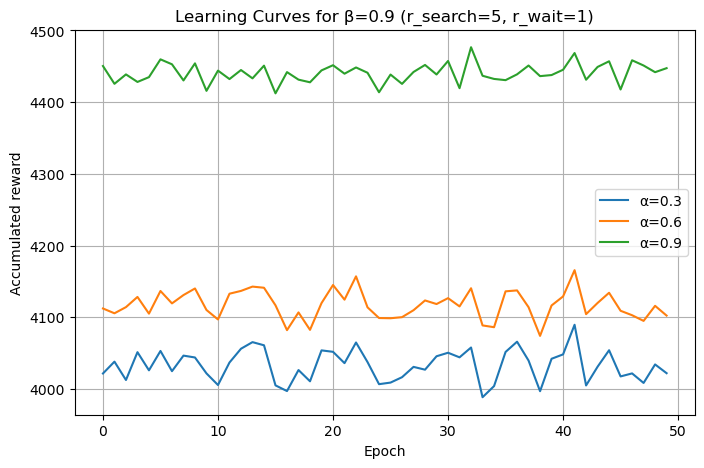

In [96]:
ALPHA_GRID = [0.3, 0.6, 0.9]
BETA_GRID = [0.3, 0.6, 0.9]

r_search = 5
r_wait = 1

for beta in BETA_GRID:
    plt.figure(figsize=(8,5))
    
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha,
                   beta=beta,
                   r_search=r_search,
                   r_wait=r_wait,
                   gamma=GAMMA,
                   rescue_penalty=RESCUE_PENALTY)

        rewards_avg, V = run_experiments(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)

        plt.plot(rewards_avg, label=f"α={alpha}")

    plt.xlabel("Epoch")
    plt.ylabel("Accumulated reward")
    plt.title(f"Learning Curves for β={beta} (r_search={r_search}, r_wait={r_wait})")
    plt.legend()
    plt.grid(True)
    plt.show()

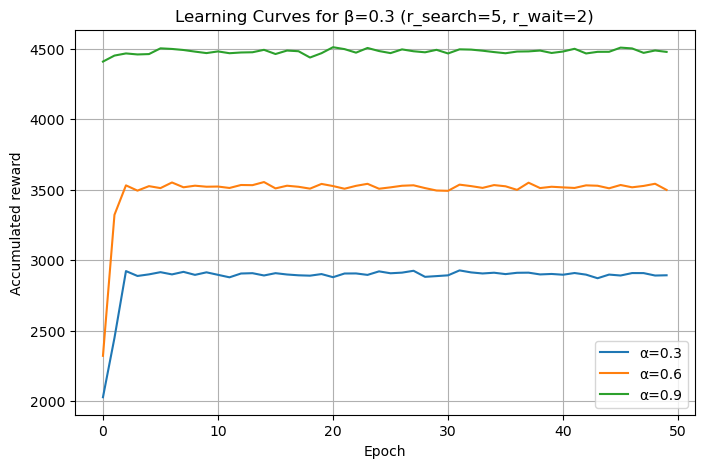

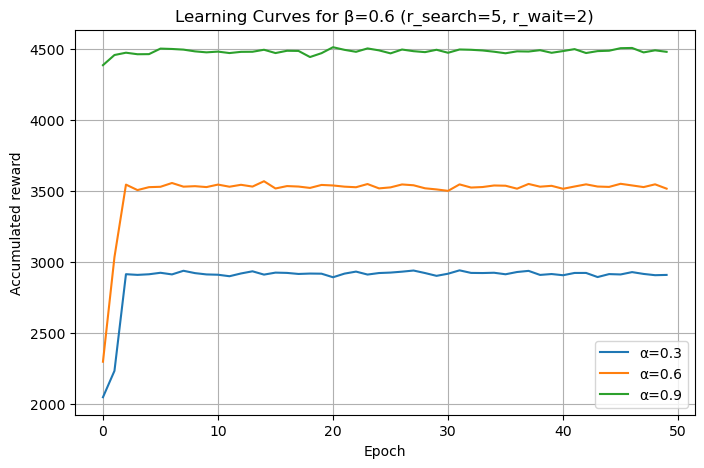

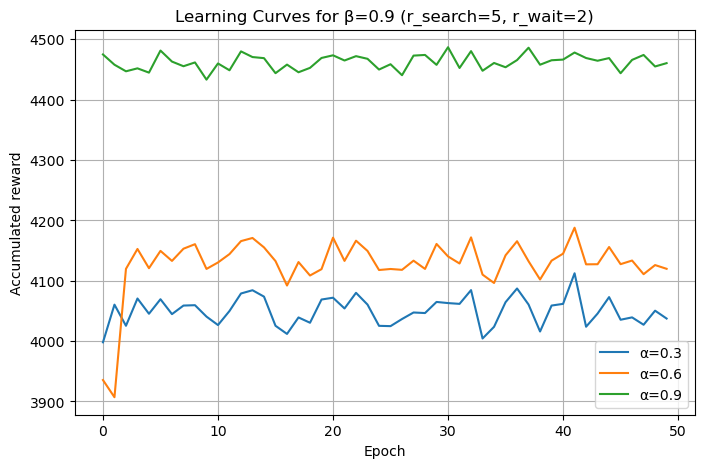

In [97]:
r_search = 5
r_wait = 2

for beta in BETA_GRID:
    plt.figure(figsize=(8,5))
    
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha,
                   beta=beta,
                   r_search=r_search,
                   r_wait=r_wait,
                   gamma=GAMMA,
                   rescue_penalty=RESCUE_PENALTY)

        rewards_avg, V = run_experiments(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)

        plt.plot(rewards_avg, label=f"α={alpha}")

    plt.xlabel("Epoch")
    plt.ylabel("Accumulated reward")
    plt.title(f"Learning Curves for β={beta} (r_search={r_search}, r_wait={r_wait})")
    plt.legend()
    plt.grid(True)
    plt.show()

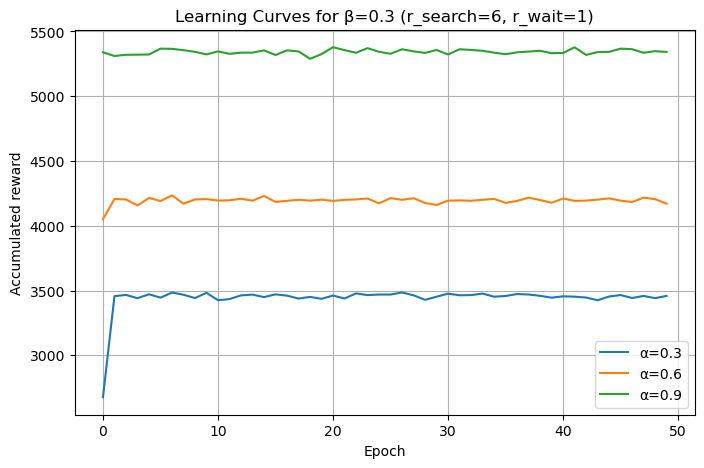

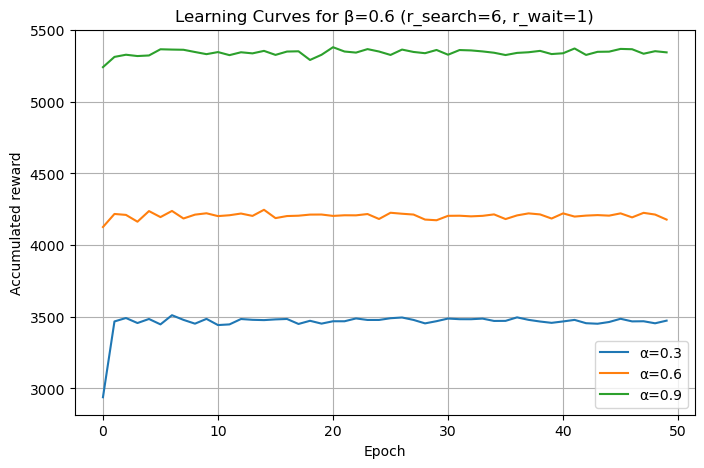

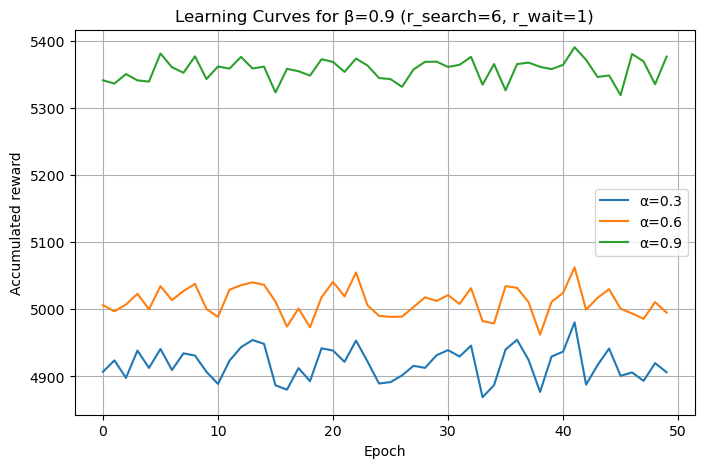

In [98]:
r_search = 6
r_wait = 1

for beta in BETA_GRID:
    plt.figure(figsize=(8,5))
    
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha,
                   beta=beta,
                   r_search=r_search,
                   r_wait=r_wait,
                   gamma=GAMMA,
                   rescue_penalty=RESCUE_PENALTY)

        rewards_avg, V = run_experiments(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)

        plt.plot(rewards_avg, label=f"α={alpha}")

    plt.xlabel("Epoch")
    plt.ylabel("Accumulated reward")
    plt.title(f"Learning Curves for β={beta} (r_search={r_search}, r_wait={r_wait})")
    plt.legend()
    plt.grid(True)
    plt.show()

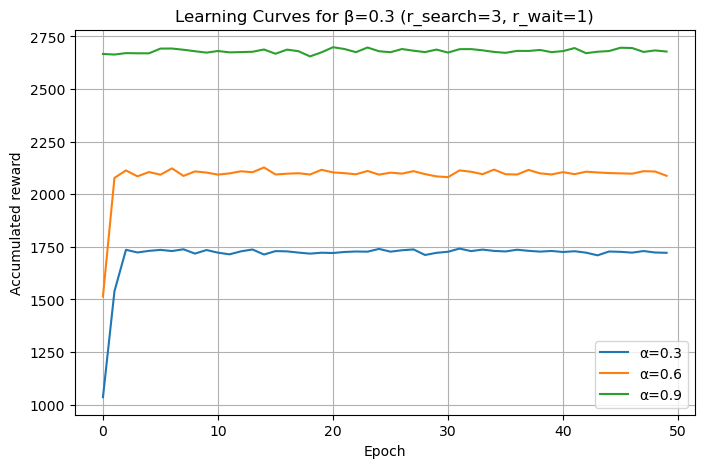

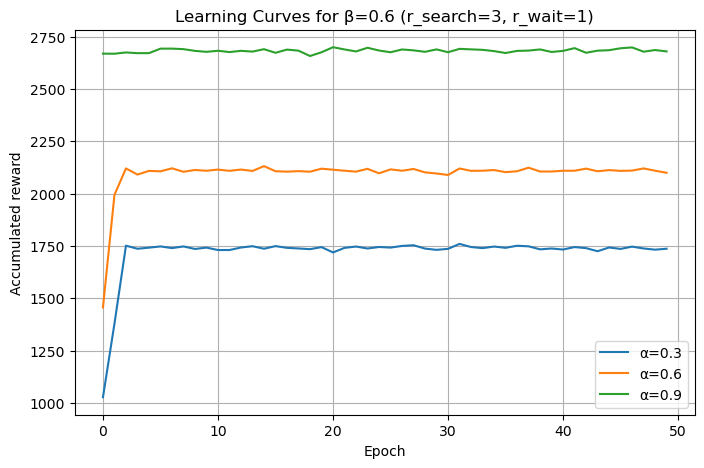

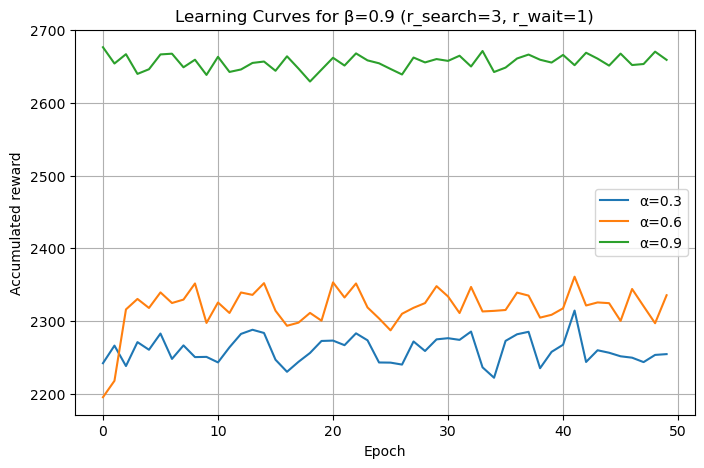

In [99]:
r_search = 3
r_wait = 1

for beta in BETA_GRID:
    plt.figure(figsize=(8,5))
    
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha,
                   beta=beta,
                   r_search=r_search,
                   r_wait=r_wait,
                   gamma=GAMMA,
                   rescue_penalty=RESCUE_PENALTY)

        rewards_avg, V = run_experiments(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)

        plt.plot(rewards_avg, label=f"α={alpha}")

    plt.xlabel("Epoch")
    plt.ylabel("Accumulated reward")
    plt.title(f"Learning Curves for β={beta} (r_search={r_search}, r_wait={r_wait})")
    plt.legend()
    plt.grid(True)
    plt.show()

### Final Setup

Training complete. Results saved to:
- Rewards file: rewards.txt
- Rewards plot: accumulated_reward.png
- Policy heatmap: optimal_policy_heatmap.png


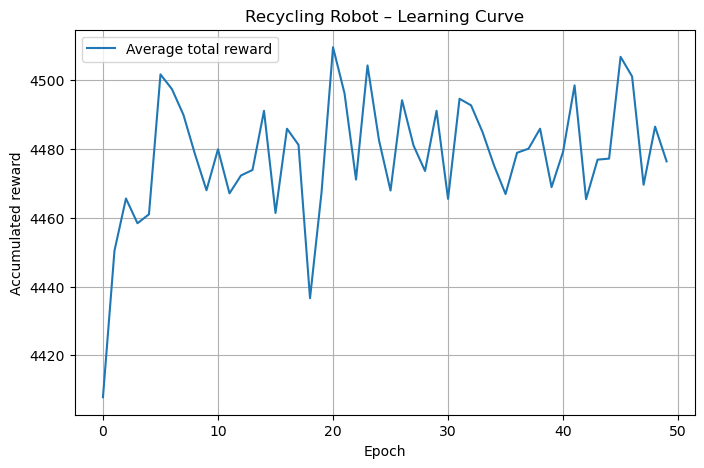

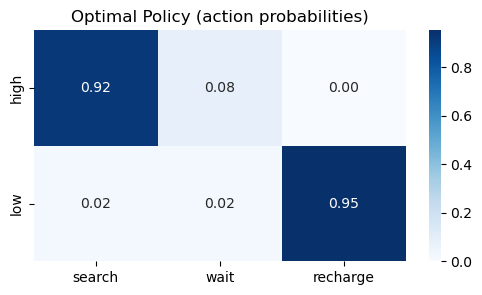

In [6]:
if __name__ == "__main__":
    p = Params(alpha=0.9,
               beta=0.3,
               r_search=5,
               r_wait=2,
               gamma=GAMMA,
               rescue_penalty=RESCUE_PENALTY)

    rewards_avg, V = run_experiments(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
    plot_rewards_curve(rewards_avg)
    plot_policy_heatmap(V, p)

    print("Training complete. Results saved to:")
    print(f"- Rewards file: {REWARDS_PATH}")
    print(f"- Rewards plot: {REWARDS_FIG}")
    print(f"- Policy heatmap: {POLICY_HEATMAP_FIG}")
